# Домашняя работа: "Методы оптимизации"

ФИО: Семенников Макар Алексеевич

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
from torch.utils.data import DataLoader, Dataset
%matplotlib inline
plt.rc('animation', html='html5')

Зафиксируем seed

In [2]:
import torch
import random
import os

def seed_everything(seed: int):
    # Для генератора случайных чисел Python
    random.seed(seed)
    
    # Для numpy
    np.random.seed(seed)
    
    # Для torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(1)

## Часть 1: Реализация методов

In [3]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

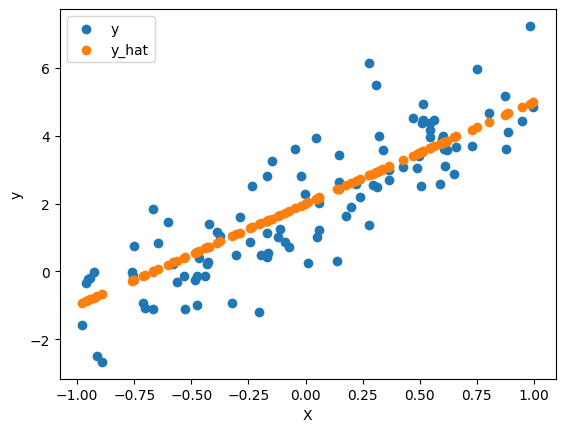

In [4]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

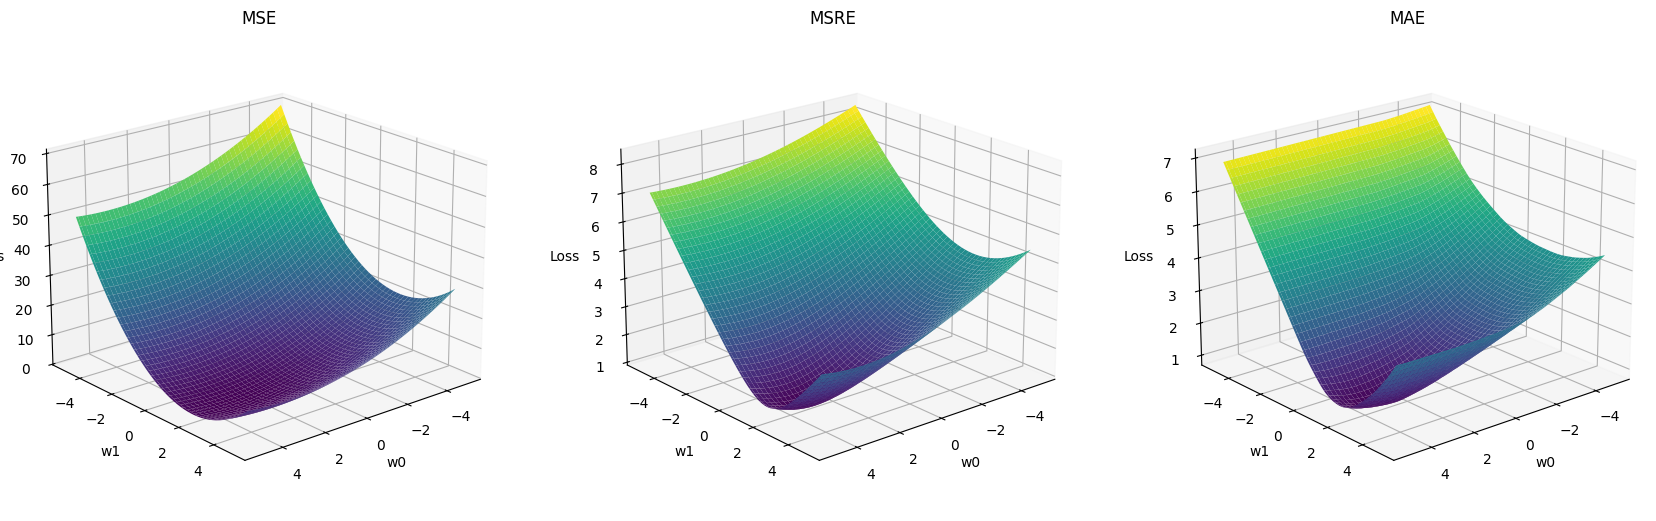

In [5]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [6]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [7]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [8]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [9]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [10]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
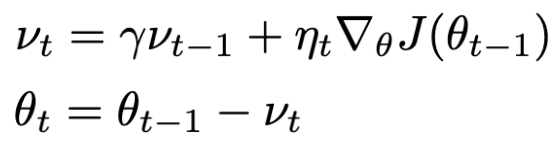

In [11]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.V = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                
                self.V[i] = self.gamma * self.V[i] + self.lr * p.grad
                p -= self.V[i]

#### AdaDelta
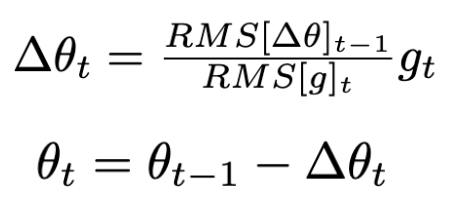

In [12]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-8, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma

        import torch

        self.delta_theta_sqr = [torch.full_like(p, 1e-3) for p in self.params]
        self.E_delta_g_sqr = [torch.full_like(p, 1e-3) for p in self.params]
        self.E_delta_theta_sqr = [torch.full_like(p, 1e-3) for p in self.params]

        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                
                self.E_delta_g_sqr[i] = self.gamma * self.E_delta_g_sqr[i] + (1 - self.gamma) * p.grad ** 2
                RMS_g = torch.sqrt(self.E_delta_g_sqr[i] + self.eta)
                
                self.E_delta_theta_sqr[i] = self.gamma * self.E_delta_theta_sqr[i] + (1 - self.gamma) * self.delta_theta_sqr[i]
                RMS_delta_theta = torch.sqrt(self.E_delta_theta_sqr[i] + self.eta)
                
                delta_theta = - (RMS_delta_theta / RMS_g) * p.grad
                p += delta_theta

                self.delta_theta_sqr[i] = delta_theta ** 2

#### Adam
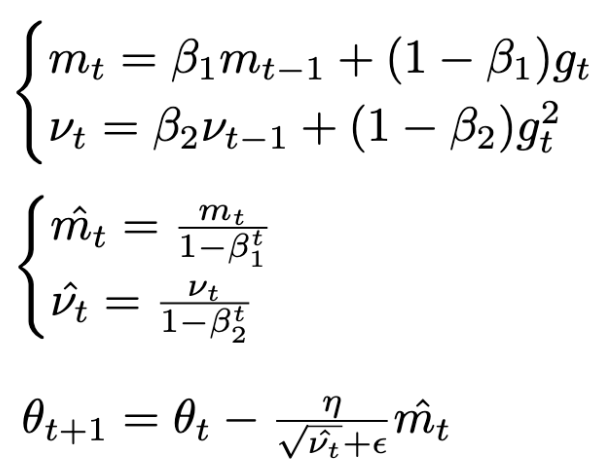

In [13]:
class Adam(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.99, lr=1e-3, eps=1e-8):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        
        self.lr = lr
        self.eps = eps
        
        self.V = [0] * len(self.params)
        self.M = [0] * len(self.params)
        
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                
                self.M[i] = self.b1 * self.M[i] + (1 - self.b1) * p.grad
                self.V[i] = self.b2 * self.V[i] + (1 - self.b2) * p.grad ** 2
                
                # Вроде как учёт количества шагов делается таким способом => несмещённость
                m_ = self.M[i] / (1 - self.b1 ** self.t)  
                v_ = self.V[i] / (1 - self.b2 ** self.t)
                
                p -= (self.lr * m_) / (torch.sqrt(v_) + self.eps)

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [14]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [15]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {}],
        ['Momentum', Momentum, {}],
        ['AdaGrad', AdaGrad, {"eta": 1e-1}],
        ['AdaDelta', AdaDelta, {}],
        ['Adam', Adam, {"lr": 1e-1}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

На видео можно заметить, что все реализации работают как надо. Видно, что:  
1) SGD работает равномерно, но медленно.
2) AdaGrad сходится очень медленно, несмотря на большое значение параметров. (Возможно такое поведение только в рамках данной задачи)
3) AdaDelta вначале резко ускоряется, а затем медленно доходит до конца.
4) Adam идёт равномерно по кратчайшей траектории и останавливается ровно в минимуме.
5) Momentum идёт быстро, но не по оптимальной траектории и совершает колебания в конце.

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [16]:
from torchvision.datasets import MNIST

In [17]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [18]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(1568, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return F.log_softmax(x, 1)

In [19]:
network = Net()
optimizer = Adam(network.parameters(), lr=1e-3)

Запустите обучение, постройте график лоссов от эпохи:

In [20]:
losses = []

network.train()
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()


    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        1, batch_idx * len(data), len(train_loader.dataset),
         100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304543
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.252625
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.164925
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.311754
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.137212
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.218892
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.027567
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.249778
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.034285
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.254788
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.048423
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.061529
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.013188
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.010093
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.030201
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.229761
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.070446
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.001151
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.012860


#### Здесь в демонстрационной функции только одна эпоха.  
#### Адаптируем для выполнения этого и следующего задания функцию обучения с одного из предыдущих семинаров

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is {device}')

Current device is cuda


In [22]:
_ = network.to(device)

In [23]:
from IPython.core.display_functions import clear_output
import sys
from torch.nn import NLLLoss


def train_custom(model, train_loader, val_loader, epochs, optimizer, optimizer_name = None, plot=True,
          verbose=True, criterion=None):
    
    criterion = criterion or NLLLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    try:
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
    
                optimizer.zero_grad()  # Обнуляем градиенты
    
                # Прямой проход
                outputs = model(inputs)
                loss = criterion(outputs, labels)
    
                # Обратный проход
                loss.backward()
                optimizer.step()
    
                # Накопление статистики
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)
    
            # Вычисляем средние значения по эпохе
            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct_train / total_train
    
            # Сохраняем значения в массивы
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
    
            # Валидация
            model.eval()  # Устанавливаем режим валидации
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
    
            with torch.no_grad():  # Отключаем градиенты для валидации
                for data in val_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
    
                    running_val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
    
            # Вычисляем средние значения по валидации
            val_loss = running_val_loss / len(val_loader)
            val_accuracy = 100 * correct_val / total_val
    
            # Сохраняем значения в массивы
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_losses[-1], val_losses[-1],
                            train_accuracies[-1], val_accuracies[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                # plt.title(f'Model with {optimizer_name} optimizer.')
                plt.subplot(1, 2, 1)
                plt.plot(train_losses, label='Train')
                plt.plot(val_losses, label='Val')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracies, label='Train accuracy')
                plt.plot(val_accuracies, label='Val accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_losses, \
           val_losses, \
           train_accuracies, \
           val_accuracies

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

### SGD

Epoch 19... (Train/Test) NLL: 0.073/0.064	Accuracy: 97.753/97.800

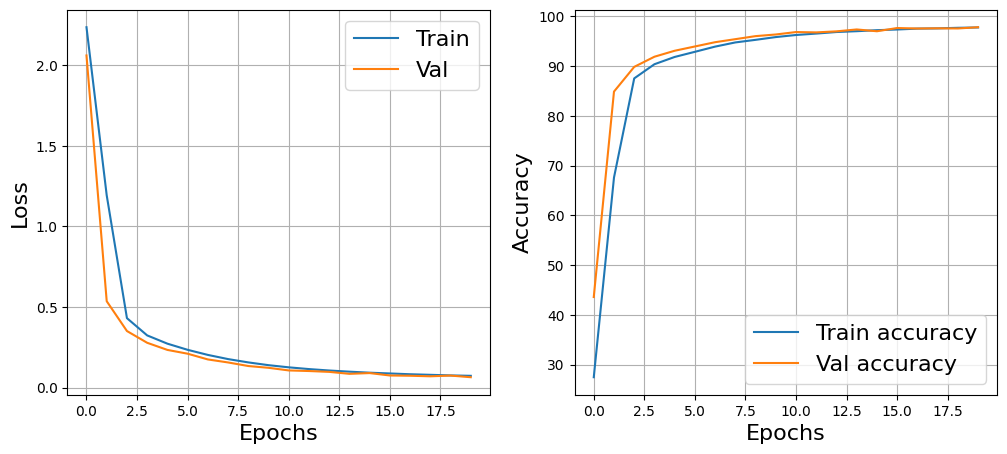

In [24]:
model = Net()
model.to(device)
optimizer = SGD(model.parameters(), lr=1e-3)
train_losses, val_losses, train_accuracies, val_accuracies = train_custom(model, train_loader, test_loader, 20, optimizer)

In [25]:
val_accuracies[-1]

97.8

### AdaGrad

Epoch 19... (Train/Test) NLL: 0.003/0.030	Accuracy: 99.960/99.130

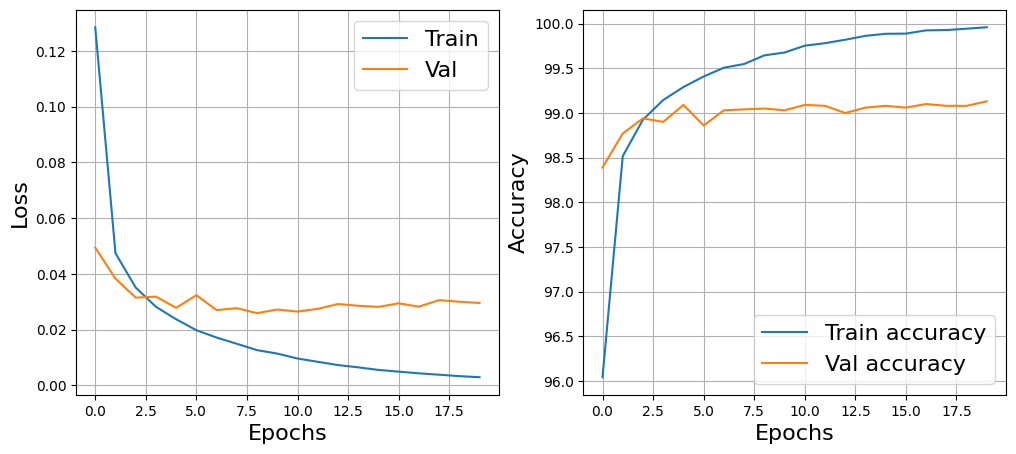

In [26]:
model = Net()
model.to(device)
optimizer = AdaGrad(model.parameters())
train_losses, val_losses, train_accuracies, val_accuracies = train_custom(model, train_loader, test_loader, 20, optimizer)

In [27]:
val_accuracies[8]

99.05

### AdaDelta

Epoch 19... (Train/Test) NLL: 0.016/0.038	Accuracy: 99.558/98.900

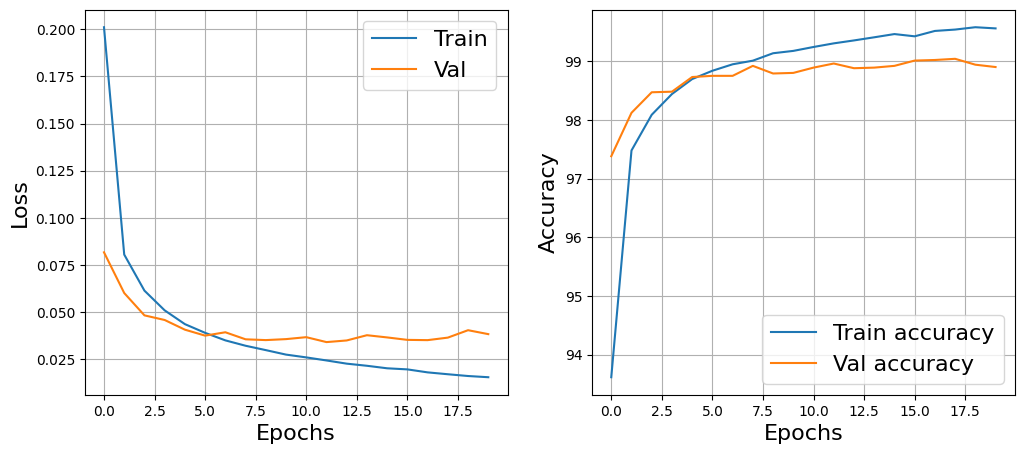

In [32]:
model = Net()
model.to(device)
optimizer = AdaDelta(model.parameters())
train_losses, val_losses, train_accuracies, val_accuracies = train_custom(model, train_loader, test_loader, 20, optimizer)

In [35]:
val_accuracies[16]

99.02

### Adam

Epoch 19... (Train/Test) NLL: 0.006/0.097	Accuracy: 99.837/98.930

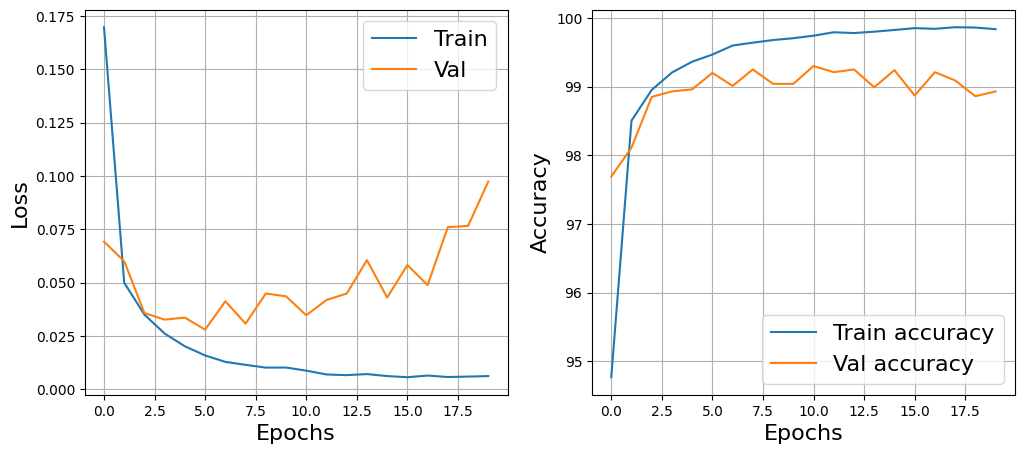

In [29]:
model = Net()
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
train_losses, val_losses, train_accuracies, val_accuracies = train_custom(model, train_loader, test_loader, 20, optimizer)

In [31]:
val_accuracies[-8]

99.25

Как можно заметить: Adam справился чуть лучше, чем остальные. Однако с ним быстрее всего было достигнуто переобучение. Как ни странно, лучшим в этом параметре оказался SGD.  
В принципе для такой задачи полноценная свёрточная сеть - "из пушки по воробьям", но даже на ней можно было посмотреть, как работают предложенные варианты оптимизаторов.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: